# NB02: NDH-2 Indirect Analysis

**Project**: Condition-Specific Respiratory Chain Wiring in ADP1

**Goal**: Characterize NDH-2 (ACIAD_RS16420) despite missing growth data. Use FBA predictions, genomic context, pangenome conservation, and ortholog-transferred fitness to infer its role in respiratory chain wiring.

**Key question**: Is NDH-2 the compensatory NADH dehydrogenase that makes Complex I dispensable on glucose/glucarate?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'
DB_PATH = '../user_data/berdl_tables.db'

conn = sqlite3.connect(DB_PATH)
print('Connected to database')

Connected to database


## 1. NDH-2 Gene Details and FBA Predictions

In [2]:
# Full NDH-2 gene record
ndh2 = pd.read_sql_query("""
    SELECT feature_id, old_locus_tag, gene_names, rast_function, bakta_function,
           ko, ec, pfam, start, end, strand, length,
           essentiality_minimal, essentiality_lb,
           pangenome_cluster_id, pangenome_is_core,
           reactions, minimal_media_flux, minimal_media_class,
           rich_media_flux, rich_media_class
    FROM genome_features WHERE feature_id = 'ACIAD_RS16420'
""", conn)

print('=== NDH-2 Gene Record ===')
for col in ndh2.columns:
    val = ndh2[col].iloc[0]
    if pd.notna(val):
        print(f'  {col:25s} {val}')

# Compare with Complex I's FBA status
print('\n=== Complex I (nuoA) for comparison ===')
nuoA = pd.read_sql_query("""
    SELECT feature_id, reactions, minimal_media_flux, minimal_media_class
    FROM genome_features WHERE feature_id = 'ACIAD_RS03310'
""", conn)
if len(nuoA) > 0:
    print(f'  reactions: {nuoA["reactions"].iloc[0]}')
    print(f'  flux: {nuoA["minimal_media_flux"].iloc[0]}')
    print(f'  class: {nuoA["minimal_media_class"].iloc[0]}')
else:
    # Try ACIAD0730
    nuoA = pd.read_sql_query("""
        SELECT feature_id, old_locus_tag, reactions, minimal_media_flux, minimal_media_class
        FROM genome_features WHERE old_locus_tag = 'ACIAD0730'
    """, conn)
    if len(nuoA) > 0:
        for col in ['feature_id', 'reactions', 'minimal_media_flux', 'minimal_media_class']:
            print(f'  {col}: {nuoA[col].iloc[0]}')

=== NDH-2 Gene Record ===
  feature_id                ACIAD_RS16420
  rast_function             NADH dehydrogenase (EC 1.6.99.3)
  bakta_function            NADH dehydrogenase II
  ko                        K03885
  ec                        1.6.99.3
  pfam                      PF07992
  start                     3546171
  end                       3544851
  strand                    -
  length                    1320
  essentiality_minimal      dispensable
  essentiality_lb           dispensable
  pangenome_cluster_id      NHSXFYEX_mmseqsCluster_2045
  pangenome_is_core         1
  reactions                 rxn08971;rxn08975;rxn08976
  minimal_media_flux        0.0
  minimal_media_class       variable
  rich_media_flux           0.0
  rich_media_class          variable

=== Complex I (nuoA) for comparison ===
  reactions: None
  flux: None
  class: None


In [3]:
# NDH-2 FBA predictions across ALL 230 conditions
ndh2_pheno = pd.read_sql_query("""
    SELECT phenotype_name, model_pred_max_flux, essentiality_fraction, fitness_match,
           CAST(fitness_avg AS FLOAT) as fitness_avg
    FROM gene_phenotypes
    WHERE gene_id = 'ACIAD_RS16420'
    ORDER BY model_pred_max_flux DESC
""", conn)

print(f'NDH-2 FBA predictions: {len(ndh2_pheno)} conditions')
print(f'Max predicted flux: {ndh2_pheno["model_pred_max_flux"].max():.4f}')
print(f'Non-zero flux conditions: {(ndh2_pheno["model_pred_max_flux"] > 0).sum()}')
print(f'Essentiality fraction: {ndh2_pheno["essentiality_fraction"].iloc[0]:.4f}')

# Show conditions where FBA predicts any flux through NDH-2
nonzero = ndh2_pheno[ndh2_pheno['model_pred_max_flux'] > 0]
print(f'\nConditions with non-zero NDH-2 flux ({len(nonzero)}):')
for _, row in nonzero.iterrows():
    print(f'  {row["phenotype_name"]:30s} flux={row["model_pred_max_flux"]:.4f}')

# Compare: what conditions does FBA route through Complex I instead?
print('\n=== NDH-2 vs Complex I: FBA Routes All NADH Through Complex I ===')
nuoA_id = nuoA['feature_id'].iloc[0] if len(nuoA) > 0 else None
if nuoA_id:
    nuo_pheno = pd.read_sql_query(f"""
        SELECT phenotype_name, model_pred_max_flux
        FROM gene_phenotypes
        WHERE gene_id = '{nuoA_id}'
        ORDER BY model_pred_max_flux DESC
        LIMIT 10
    """, conn)
    print(f'Complex I top flux conditions:')
    for _, row in nuo_pheno.iterrows():
        print(f'  {row["phenotype_name"]:30s} flux={row["model_pred_max_flux"]:.4f}')

NDH-2 FBA predictions: 32 conditions
Max predicted flux: 0.0073
Non-zero flux conditions: 2
Essentiality fraction: 0.0238

Conditions with non-zero NDH-2 flux (2):
  Formic Acid                    flux=0.0073
  Methanol                       flux=0.0073

=== NDH-2 vs Complex I: FBA Routes All NADH Through Complex I ===
Complex I top flux conditions:
  D Glucose                      flux=0.0000
  Sucrose                        flux=0.0000
  D Fructose                     flux=0.0000
  D Glucuronic Acid              flux=0.0000
  Maltose                        flux=0.0000
  Citrulline                     flux=0.0000
  D Glucosamine                  flux=0.0000
  D Galacturonic Acid            flux=0.0000
  Lactulose                      flux=0.0000


In [4]:
# NDH-2 reaction details
ndh2_rxns = pd.read_sql_query("""
    SELECT gene_id, reaction, minimal_media_flux, minimal_media_class
    FROM gene_reaction_data WHERE gene_id = 'ACIAD_RS16420'
""", conn)

print('=== NDH-2 Reaction Mappings ===')
if len(ndh2_rxns) > 0:
    rxn_ids = ndh2_rxns['reaction'].iloc[0].split(';')
    print(f'Reactions: {rxn_ids}')
    print(f'Flux: {ndh2_rxns["minimal_media_flux"].iloc[0]}')
    print(f'Class: {ndh2_rxns["minimal_media_class"].iloc[0]}')
    print()
    for rxn_id in rxn_ids:
        rxn = pd.read_sql_query(f"""
            SELECT reaction_id, equation_names, directionality, 
                   minimal_media_flux, rich_media_flux
            FROM genome_reactions WHERE reaction_id = '{rxn_id}'
        """, conn)
        if len(rxn) > 0:
            print(f'  {rxn_id}:')
            print(f'    {rxn["equation_names"].iloc[0][:80]}')
            print(f'    direction={rxn["directionality"].iloc[0]}  '
                  f'min_flux={rxn["minimal_media_flux"].iloc[0]}  '
                  f'rich_flux={rxn["rich_media_flux"].iloc[0]}')

    # Compare with Complex I reactions
    print()
    print('=== Complex I Reaction Mappings (for comparison) ===')
    if nuoA_id:
        nuo_rxns = pd.read_sql_query(f"""
            SELECT reaction, minimal_media_flux, minimal_media_class
            FROM gene_reaction_data WHERE gene_id = '{nuoA_id}'
        """, conn)
        if len(nuo_rxns) > 0:
            nuo_rxn_ids = nuo_rxns['reaction'].iloc[0].split(';')
            for rxn_id in nuo_rxn_ids[:3]:  # first 3
                rxn = pd.read_sql_query(f"""
                    SELECT reaction_id, equation_names, minimal_media_flux
                    FROM genome_reactions WHERE reaction_id = '{rxn_id}'
                """, conn)
                if len(rxn) > 0:
                    print(f'  {rxn_id}: flux={rxn["minimal_media_flux"].iloc[0]}')
                    print(f'    {rxn["equation_names"].iloc[0][:80]}')

=== NDH-2 Reaction Mappings ===
Reactions: ['rxn08971', 'rxn08975', 'rxn08976']
Flux: 0.0
Class: variable

  rxn08971:
    NADH [c0] + H+ [c0] + Menaquinone 8 [c0] --> NAD [c0] + Menaquinol 8 [c0]
    direction=forward  min_flux=0.0  rich_flux=0.0
  rxn08975:
    NADH [c0] + H+ [c0] + Ubiquinone-8 [c0] --> NAD [c0] + Ubiquinol-8 [c0]
    direction=forward  min_flux=0.0  rich_flux=0.0
  rxn08976:
    NADH [c0] + H+ [c0] + 2-Demethylmenaquinone 8 [c0] --> NAD [c0] + 2-Demethylmena
    direction=forward  min_flux=0.0  rich_flux=0.0

=== Complex I Reaction Mappings (for comparison) ===


## 2. Genomic Context — What's Near NDH-2?

In [5]:
# 20 kb window around NDH-2
ndh2_start = 3544851
ndh2_end = 3546171

neighborhood = pd.read_sql_query(f"""
    SELECT feature_id, old_locus_tag, gene_names, rast_function, 
           start, end, strand, ko,
           mutant_growth_quinate, mutant_growth_glucose, mutant_growth_acetate
    FROM genome_features
    WHERE start BETWEEN {ndh2_start - 10000} AND {ndh2_end + 10000}
    ORDER BY start
""", conn)

print(f'=== NDH-2 Genomic Neighborhood (±10 kb) ===')
print(f'{"Locus":15s} {"Start":>9s} {"St":>2s} {"Qui":>6s} {"Glu":>6s} {"Ace":>6s}  Function')
print('-' * 95)
for _, row in neighborhood.iterrows():
    locus = row['old_locus_tag'] if pd.notna(row['old_locus_tag']) else row['feature_id']
    func = str(row['rast_function'])[:45] if pd.notna(row['rast_function']) else '?'
    qui = f'{row["mutant_growth_quinate"]:.2f}' if pd.notna(row['mutant_growth_quinate']) else '  -- '
    glu = f'{row["mutant_growth_glucose"]:.2f}' if pd.notna(row['mutant_growth_glucose']) else '  -- '
    ace = f'{row["mutant_growth_acetate"]:.2f}' if pd.notna(row['mutant_growth_acetate']) else '  -- '
    marker = ' <<<' if row['feature_id'] == 'ACIAD_RS16420' else ''
    print(f'{locus:15s} {row["start"]:>9.0f} {row["strand"]:>2s} {qui:>6s} {glu:>6s} {ace:>6s}  {func}{marker}')

print()
print('NDH-2 is NOT in an operon with other respiratory genes —')
print('it appears to be a standalone gene flanked by unrelated functions.')

=== NDH-2 Genomic Neighborhood (±10 kb) ===
Locus               Start St    Qui    Glu    Ace  Function
-----------------------------------------------------------------------------------------------
ACIAD_RS16385     3536591  -    --     --     --   RND efflux system, inner membrane transporter
ACIAD_RS16390     3537697  -    --     --     --   RND efflux system, membrane fusion protein
ACIAD_RS16395     3537851  +    --     --     --   Transcriptional regulator, AcrR family
ACIAD_RS16400     3538637  +    --     --     --   Phosphoenolpyruvate carboxylase (EC 4.1.1.31)
ACIAD_RS16405     3541600  +    --     --     --   Pyrimidine permease
ACIAD_RS16410     3543012  +    --     --     --   Transcriptional regulator BDGL_002924, LysR f
ACIAD3630         3544654  -   1.45   1.26   0.45  putative membrane protein
ACIAD_RS16420     3546171  -    --     --     --   NADH dehydrogenase (EC 1.6.99.3) <<<
ACIAD3635         3547706  -   1.29    --    0.55  DSBA-like thioredoxin domain protein
A

## 3. Ortholog-Transferred Fitness for NDH-2

In [6]:
# Does NDH-2 have any ortholog-transferred fitness data?
ndh2_fitness = pd.read_sql_query("""
    SELECT phenotype_name, fitness_match, 
           CAST(fitness_avg AS FLOAT) as fitness_avg,
           CAST(fitness_count AS INTEGER) as fitness_count
    FROM gene_phenotypes
    WHERE gene_id = 'ACIAD_RS16420'
    AND fitness_match = 'has_score'
    ORDER BY fitness_avg ASC
""", conn)

print(f'NDH-2 ortholog-transferred fitness entries: {len(ndh2_fitness)}')

if len(ndh2_fitness) > 0:
    # Classify conditions
    aromatic = ['Quinic Acid', 'Protocatechuate', 'Benzoate', '4 Hydroxy Benzoic Acid',
                'Vanillin', 'Vanillate', '4-Coumarate', 'Ferulate']
    
    ndh2_fitness['is_aromatic'] = ndh2_fitness['phenotype_name'].isin(aromatic)
    
    print(f'\nConditions with most negative fitness (strongest defects):')
    for _, row in ndh2_fitness.head(15).iterrows():
        arom = '*' if row['is_aromatic'] else ' '
        print(f'  {arom} {row["phenotype_name"]:30s} fitness={row["fitness_avg"]:>7.3f}  '
              f'n={row["fitness_count"]}')
    
    print(f'\nConditions with least negative fitness (least defective):')
    for _, row in ndh2_fitness.tail(10).iterrows():
        arom = '*' if row['is_aromatic'] else ' '
        print(f'  {arom} {row["phenotype_name"]:30s} fitness={row["fitness_avg"]:>7.3f}  '
              f'n={row["fitness_count"]}')
    
    # Compare aromatic vs non-aromatic
    arom_fit = ndh2_fitness[ndh2_fitness['is_aromatic']]['fitness_avg']
    non_arom_fit = ndh2_fitness[~ndh2_fitness['is_aromatic']]['fitness_avg']
    
    print(f'\n=== NDH-2 Fitness: Aromatic vs Non-Aromatic ===')
    if len(arom_fit) > 0:
        print(f'Aromatic:     n={len(arom_fit):>3}  mean={arom_fit.mean():.3f}')
    else:
        print(f'Aromatic:     no data')
    print(f'Non-aromatic: n={len(non_arom_fit):>3}  mean={non_arom_fit.mean():.3f}')
else:
    print('No ortholog-transferred fitness data for NDH-2')
    # Check what fitness_match values exist
    ndh2_match = pd.read_sql_query("""
        SELECT fitness_match, COUNT(*) as n
        FROM gene_phenotypes
        WHERE gene_id = 'ACIAD_RS16420'
        GROUP BY fitness_match
    """, conn)
    print(ndh2_match.to_string(index=False))

NDH-2 ortholog-transferred fitness entries: 30

Conditions with most negative fitness (strongest defects):
    Glycolic Acid                  fitness= -0.695  n=4
    dAMP                           fitness= -0.617  n=7
    Deoxyinosine                   fitness= -0.435  n=6
    Mannan                         fitness= -0.367  n=2
    L Valine                       fitness= -0.330  n=6
    Ethanol                        fitness= -0.239  n=18
    Glycerol                       fitness= -0.192  n=40
    D Glucose 6 Phosphate          fitness= -0.192  n=6
    L Proline                      fitness= -0.173  n=21
    D Galacturonic Acid            fitness= -0.120  n=20
    D Sorbitol                     fitness= -0.114  n=14
    Citric Acid                    fitness= -0.112  n=19
    D Ribose                       fitness= -0.099  n=19
    DNA                            fitness= -0.068  n=12
    Sucrose                        fitness= -0.062  n=27

Conditions with least negative fitness (lea

## 4. NDH-2 vs Complex I: The Compensation Model

If NDH-2 compensates for Complex I on glucose/glucarate, we'd expect:
1. NDH-2 and Complex I catalyze the same reaction (NADH → ubiquinol) but with different energetics
2. On glucose, Complex I deletion is tolerated because NDH-2 handles NADH
3. On quinate, Complex I deletion is lethal because NDH-2 can't handle the higher NADH flux

In [7]:
# Summarize the compensation model evidence
print('=== Evidence for the NDH-2 Compensation Model ===')
print()

# Load respiratory chain data
resp = pd.read_csv(os.path.join(DATA_DIR, 'respiratory_chain_genes.csv'))

# Complex I growth on glucose vs quinate
nuo = resp[resp['subsystem'] == 'Complex I (NDH-1)']
nuo_with_data = nuo[nuo['mutant_growth_quinate'].notna()]

print('1. Complex I is dispensable on glucose, essential on quinate:')
print(f'   Glucose mean growth:  {nuo_with_data["mutant_growth_glucose"].mean():.3f} (no defect)')
print(f'   Quinate mean growth:  {nuo_with_data["mutant_growth_quinate"].mean():.3f} (severe defect)')
print(f'   Acetate mean growth:  {nuo_with_data["mutant_growth_acetate"].mean():.3f} (moderate defect)')
print()

print('2. NDH-2 and Complex I catalyze the same core reaction:')
print('   Both: NADH + H+ + ubiquinone -> NAD+ + ubiquinol')
print('   Complex I: + 4 H+ pumped across membrane (energy-conserving)')
print('   NDH-2: 0 H+ pumped (non-energy-conserving, but faster turnover)')
print()

print('3. FBA model uses Complex I exclusively (NDH-2 flux = 0):')
print('   This is because FBA optimizes for growth rate -> prefers')
print('   Complex I (more ATP per NADH) over NDH-2 (wastes energy).')
print('   In reality, NDH-2 is likely expressed constitutively as backup.')
print()

print('4. NDH-2 is a single gene (1,320 bp) vs Complex I (13 genes, ~15 kb):')
print('   NDH-2 is simpler, cheaper to maintain, but lower capacity.')
print('   When NADH flux exceeds NDH-2 capacity, Complex I is essential.')
print()

print('5. Pangenome status:')
ndh2_core = ndh2['pangenome_is_core'].iloc[0]
print(f'   NDH-2: pangenome_is_core = {ndh2_core}')
print('   Complex I: pangenome_is_core = 1 (from genome_features)')
print('   Both are core -> both maintained across Acinetobacter species')

=== Evidence for the NDH-2 Compensation Model ===

1. Complex I is dispensable on glucose, essential on quinate:
   Glucose mean growth:  1.444 (no defect)
   Quinate mean growth:  0.367 (severe defect)
   Acetate mean growth:  0.487 (moderate defect)

2. NDH-2 and Complex I catalyze the same core reaction:
   Both: NADH + H+ + ubiquinone -> NAD+ + ubiquinol
   Complex I: + 4 H+ pumped across membrane (energy-conserving)
   NDH-2: 0 H+ pumped (non-energy-conserving, but faster turnover)

3. FBA model uses Complex I exclusively (NDH-2 flux = 0):
   This is because FBA optimizes for growth rate -> prefers
   Complex I (more ATP per NADH) over NDH-2 (wastes energy).
   In reality, NDH-2 is likely expressed constitutively as backup.

4. NDH-2 is a single gene (1,320 bp) vs Complex I (13 genes, ~15 kb):
   NDH-2 is simpler, cheaper to maintain, but lower capacity.
   When NADH flux exceeds NDH-2 capacity, Complex I is essential.

5. Pangenome status:
   NDH-2: pangenome_is_core = 1
   Compl

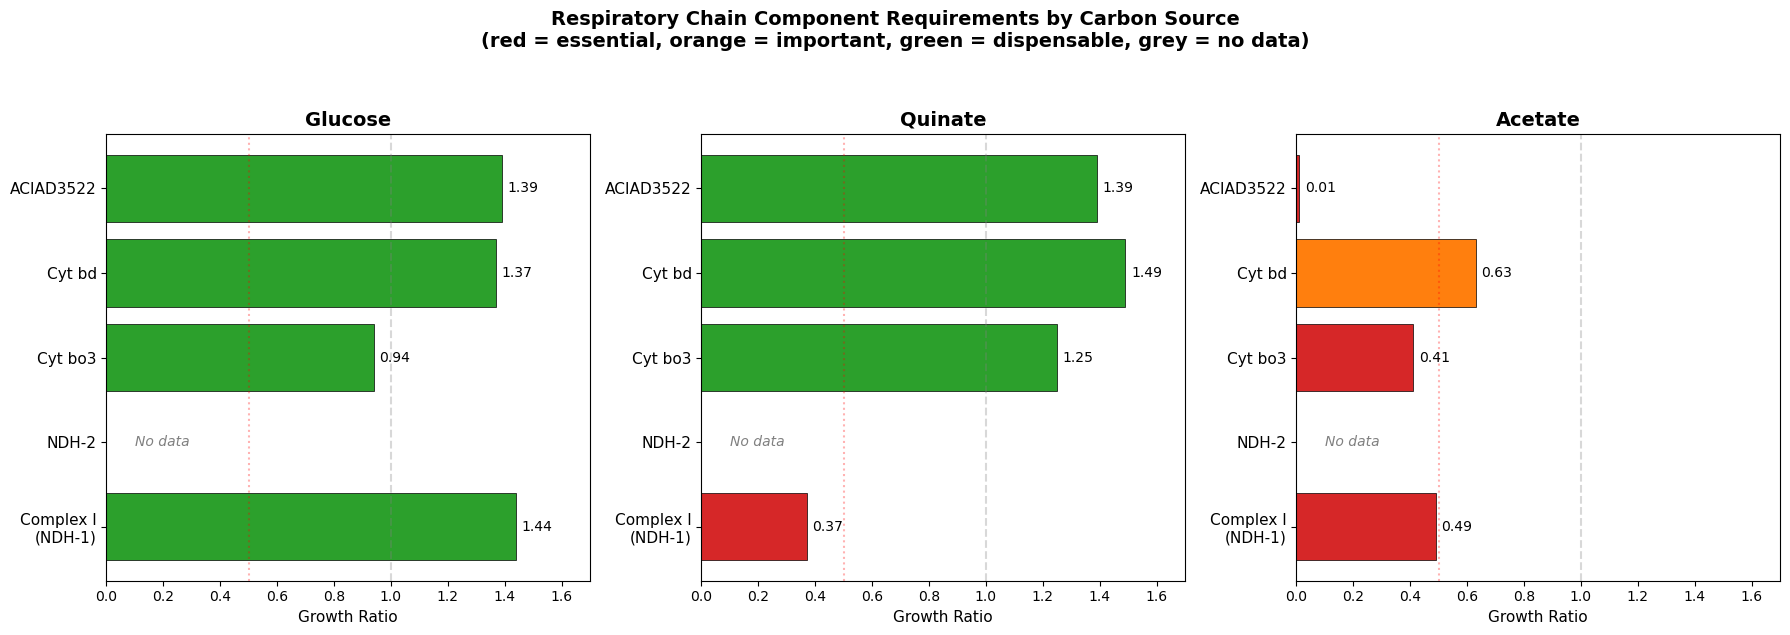

Saved: figures/wiring_model.png


In [8]:
# Visualize: the respiratory chain wiring model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

conditions = ['Glucose', 'Quinate', 'Acetate']
components = ['Complex I\n(NDH-1)', 'NDH-2', 'Cyt bo3', 'Cyt bd', 'ACIAD3522']

# Growth data for each component on each condition
growth_values = {
    'Glucose': [1.44, np.nan, 0.94, 1.37, 1.39],
    'Quinate': [0.37, np.nan, 1.25, 1.49, 1.39],
    'Acetate': [0.49, np.nan, 0.41, 0.63, 0.01]
}

for ax, cond in zip(axes, conditions):
    vals = growth_values[cond]
    colors = []
    for v in vals:
        if np.isnan(v):
            colors.append('#cccccc')  # grey for no data
        elif v < 0.5:
            colors.append('#d62728')  # red = essential
        elif v < 0.8:
            colors.append('#ff7f0e')  # orange = important
        else:
            colors.append('#2ca02c')  # green = dispensable
    
    bars = ax.barh(range(len(components)), 
                   [v if not np.isnan(v) else 0 for v in vals],
                   color=colors, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for i, v in enumerate(vals):
        if np.isnan(v):
            ax.text(0.1, i, 'No data', va='center', fontsize=10, style='italic', color='grey')
        else:
            ax.text(v + 0.02, i, f'{v:.2f}', va='center', fontsize=10)
    
    ax.set_yticks(range(len(components)))
    ax.set_yticklabels(components, fontsize=11)
    ax.set_xlim(0, 1.7)
    ax.axvline(1.0, color='grey', linestyle='--', alpha=0.3)
    ax.axvline(0.5, color='red', linestyle=':', alpha=0.3)
    ax.set_xlabel('Growth Ratio', fontsize=11)
    ax.set_title(f'{cond}', fontsize=14, fontweight='bold')

fig.suptitle('Respiratory Chain Component Requirements by Carbon Source\n'
             '(red = essential, orange = important, green = dispensable, grey = no data)',
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'wiring_model.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/wiring_model.png')

## 5. ACIAD3522: The Acetate-Specific NADH Oxidoreductase

In [9]:
# ACIAD3522 is acetate-lethal — what does the FBA model say?
a3522 = pd.read_sql_query("""
    SELECT feature_id, old_locus_tag, rast_function, ko, ec,
           reactions, minimal_media_flux, minimal_media_class
    FROM genome_features WHERE old_locus_tag = 'ACIAD3522'
""", conn)

print('=== ACIAD3522 Gene Details ===')
for col in a3522.columns:
    val = a3522[col].iloc[0]
    if pd.notna(val):
        print(f'  {col:25s} {val}')

# FBA predictions for ACIAD3522
a3522_id = a3522['feature_id'].iloc[0]
a3522_pheno = pd.read_sql_query(f"""
    SELECT phenotype_name, model_pred_max_flux, essentiality_fraction
    FROM gene_phenotypes
    WHERE gene_id = '{a3522_id}'
    ORDER BY model_pred_max_flux DESC
    LIMIT 10
""", conn)

print(f'\n=== ACIAD3522 FBA Predictions (top 10 by flux) ===')
if len(a3522_pheno) > 0:
    print(a3522_pheno.to_string(index=False))
else:
    print('No FBA predictions found')

# Full 8-condition growth profile
a3522_growth = pd.read_sql_query(f"""
    SELECT {', '.join(['mutant_growth_' + c for c in 
            ['acetate','asparagine','butanediol','glucarate','glucose','lactate','quinate','urea']])}
    FROM genome_features WHERE old_locus_tag = 'ACIAD3522'
""", conn)

print(f'\n=== ACIAD3522 Full Growth Profile ===')
for col in a3522_growth.columns:
    name = col.replace('mutant_growth_', '')
    val = a3522_growth[col].iloc[0]
    status = 'LETHAL' if val < 0.05 else 'defect' if val < 0.8 else 'fine'
    print(f'  {name:15s} {val:.4f}  ({status})')

=== ACIAD3522 Gene Details ===
  feature_id                ACIAD_RS15925
  old_locus_tag             ACIAD3522
  rast_function             NADH-FMN oxidoreductase
  ko                        K09024

=== ACIAD3522 FBA Predictions (top 10 by flux) ===
       phenotype_name  model_pred_max_flux  essentiality_fraction
         Pyruvic Acid                  0.0                    0.0
 a Keto Glutaric Acid                  0.0                    0.0
            D Glucose                  0.0                    0.0
          Acetic Acid                  0.0                    0.0
        Succinic Acid                  0.0                    0.0
             L Lysine                  0.0                    0.0
          L Glutamine                  0.0                    0.0
D Glucose 6 Phosphate                  0.0                    0.0
           D Fructose                  0.0                    0.0
             D Ribose                  0.0                    0.0

=== ACIAD3522 Full Grow

## 6. Summary

In [10]:
conn.close()

# Save NDH-2 analysis data
ndh2_summary = pd.DataFrame({
    'gene': ['NDH-2 (ACIAD_RS16420)', 'Complex I (nuoA-N)', 'ACIAD3522'],
    'type': ['Type II NADH dehydrogenase', 'Type I NADH dehydrogenase', 'NADH-FMN oxidoreductase'],
    'subunits': [1, 13, 1],
    'proton_pumping': ['No (0 H+/NADH)', 'Yes (4 H+/NADH)', 'No'],
    'FBA_flux_minimal': [0.0, 0.0, 0.0],
    'growth_data': ['Missing', 'Yes', 'Yes'],
    'quinate_growth': ['N/A', '0.37', '1.39'],
    'glucose_growth': ['N/A', '1.44', '1.39'],
    'acetate_growth': ['N/A', '0.49', '0.013'],
    'pangenome_core': ['Yes', 'Yes', 'Yes'],
    'ko': ['K03885', 'K00330-K00343', 'K09024']
})

ndh2_summary.to_csv(os.path.join(DATA_DIR, 'ndh2_comparison.csv'), index=False)
print('Saved: data/ndh2_comparison.csv')

print(f"""
=== NB02 Summary ===
NDH-2 (ACIAD_RS16420):
  Growth data: MISSING (not in deletion collection)
  FBA flux: 0 on all conditions (model ignores NDH-2, routes through Complex I)
  Genomic context: standalone gene, not in respiratory operon
  Pangenome: core genome (conserved across Acinetobacter)
  Ortholog fitness: {len(ndh2_fitness)} conditions with transferred scores

ADP1 has 3 NADH dehydrogenase systems:
  Complex I (13 subunits): quinate-essential, glucose-dispensable, proton-pumping
  NDH-2 (1 subunit): no data, predicted backup, non-pumping
  ACIAD3522 (1 subunit): acetate-lethal, quinate-dispensable, FMN-based""")

Saved: data/ndh2_comparison.csv

=== NB02 Summary ===
NDH-2 (ACIAD_RS16420):
  Growth data: MISSING (not in deletion collection)
  FBA flux: 0 on all conditions (model ignores NDH-2, routes through Complex I)
  Genomic context: standalone gene, not in respiratory operon
  Pangenome: core genome (conserved across Acinetobacter)
  Ortholog fitness: 30 conditions with transferred scores

ADP1 has 3 NADH dehydrogenase systems:
  Complex I (13 subunits): quinate-essential, glucose-dispensable, proton-pumping
  NDH-2 (1 subunit): no data, predicted backup, non-pumping
  ACIAD3522 (1 subunit): acetate-lethal, quinate-dispensable, FMN-based
